In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Parameters of the Axelrod model
L = 32
F_values = [2, 3, 10]

# Parameter for the noise
noise = 0.01 # probability of random cultural drift

# Parameter for the mass media influence
media = 0.01 # probability of adopting the global culture

In [6]:
def initialize_culture_grid(L, F, q):
    """
    Initialize the culture grid.

    Parameters:
        L (int): size of the grid
        F (int): number of features
        q (int): number of traits per feature

    Returns:
        np.array: the culture grid
    """
    return np.random.randint(q, size=(L, L, F))

def calculate_global_culture(culture_grid):
    """
    Calculate the most common culture in the culture grid.

    Parameters:
        culture_grid (np.array): the culture grid

    Returns:
        np.array: the most common culture
    """
    L, _, F = culture_grid.shape
    culture_int = np.sum(culture_grid * (q ** np.arange(F)), axis=2)
    unique_vals, counts = np.unique(culture_int, return_counts=True)
    most_common_culture_int = unique_vals[np.argmax(counts)]
    most_common_culture = np.zeros(F)
    for i in range(F-1, -1, -1):
        most_common_culture[i] = most_common_culture_int % q
        most_common_culture_int //= q
    return most_common_culture

def simulation_step(culture_grid, L):
    """
    Perform a simulation step.

    Parameters:
        culture_grid (np.array): the culture grid
        L (int): size of the grid
        F (int): number of features
        q (int): number of traits per feature

    Returns:
        np.array: the updated culture grid
    """
    # Randomly select an agent
    x, y = np.random.randint(L, size=2)

    # Randomly select a neighbor
    dx, dy = np.random.choice([-1, 0, 1], size=2)
    nx, ny = (x + dx) % L, (y + dy) % L  # periodic boundary conditions

    # If they share at least one cultural feature
    if any(culture_grid[x, y, :] == culture_grid[nx, ny, :]):
        # The agent adopts one differing feature from the neighbor
        differing_features = np.where(culture_grid[x, y, :] != culture_grid[nx, ny, :])[0]
        if len(differing_features) > 0:
            f = np.random.choice(differing_features)
            culture_grid[x, y, f] = culture_grid[nx, ny, f]

    return culture_grid

def simulation_step_with_noise(culture_grid, L, noise):
    """
    Perform a simulation step with noise.

    Parameters:
        culture_grid (np.array): the culture grid
        L (int): size of the grid
        F (int): number of features
        q (int): number of traits per feature
        noise (float): probability of random cultural drift

    Returns:
        np.array: the updated culture grid
    """
    # Perform a normal simulation step
    simulation_step(culture_grid, L)

    # With a small probability, an agent randomly changes one of its features
    if np.random.rand() < noise:
        x, y = np.random.randint(L, size=2)
        f = np.random.randint(F)
        culture_grid[x, y, f] = np.random.randint(q)

    return culture_grid

def simulation_step_with_noise_and_media(culture_grid, L, media):
    """
    Perform a simulation step with noise and media influence.

    Parameters:
        culture_grid (np.array): the culture grid
        L (int): size of the grid
        F (int): number of features
        q (int): number of traits per feature
        noise (float): probability of random cultural drift
        media (float): probability of adopting the global culture

    Returns:
        np.array: the updated culture grid
    """
    # The global culture
    global_culture = calculate_global_culture(culture_grid)

    # Perform a simulation step with noise
    simulation_step_with_noise(culture_grid, L, noise)

    # With a small probability, an agent adopts the global culture
    if np.random.rand() < media:
        x, y = np.random.randint(L, size=2)
        culture_grid[x, y, :] = global_culture

    return culture_grid

def calculate_Smax_norm(culture_grid):
    """
    Calculate the size of the largest homogeneous domain (Smax).

    Parameters:
        culture_grid (np.array): the culture grid

    Returns:
        int: Smax value
    """
    L, _, F = culture_grid.shape
    culture_int = np.sum(culture_grid * (q ** np.arange(F)), axis=2)
    unique_vals, counts = np.unique(culture_int, return_counts=True)
    max_count = np.max(counts)
    Smax_norm = max_count / (L ** 2)

    return Smax_norm

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


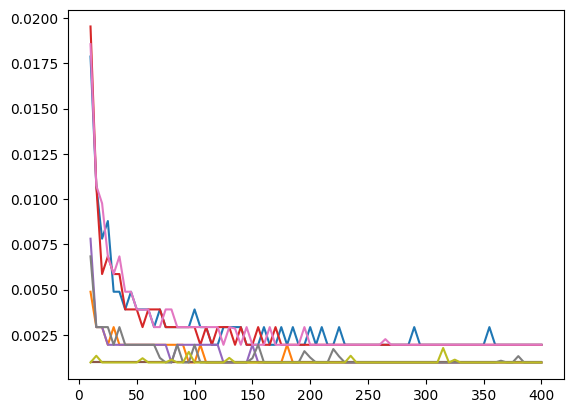

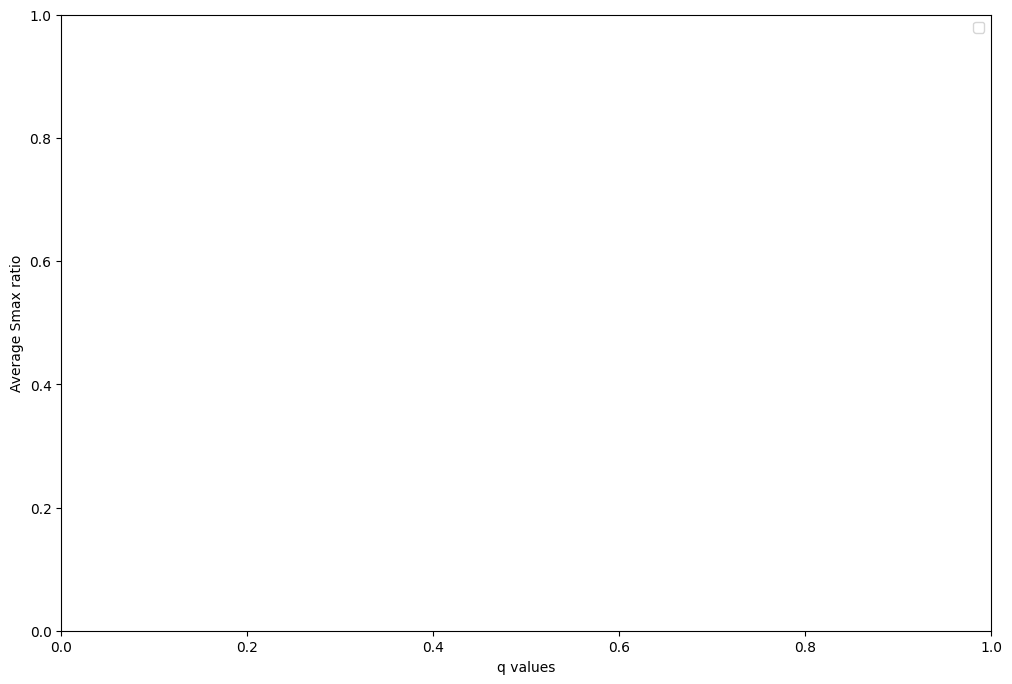

In [7]:
# Define the range of q values and the number of simulation steps
q_values = range(10, 401, 5)
num_steps = 50

# Define the list of simulations
simulations = [simulation_step,
               simulation_step_with_noise,
               simulation_step_with_noise_and_media]

# Initialize an empty dictionary to store the results
smax_avg_dict = {}

# Iterate over the simulations and their respective additional arguments
for sim in simulations:
    # Iterate over the F values
    for F in F_values:
        # Initialize an empty list to store the Smax_norm values for this simulation and F value
        smax_avg_list = []

        # Iterate over the q values
        for q in q_values:
            # Initialize the culture grid
            culture_grid = initialize_culture_grid(L, F, q)

            # Initialize an empty list to store the Smax_norm values for this q value
            smax_norm_list = []

            # Perform the simulation steps
            for _ in range(num_steps):
                # Perform the simulation step with the necessary arguments
                if sim == simulation_step:
                    culture_grid = sim(culture_grid, L)
                elif sim == simulation_step_with_noise:
                    culture_grid = sim(culture_grid, L, noise)
                elif sim == simulation_step_with_noise_and_media:
                    culture_grid = sim(culture_grid, L, media)

                # Calculate Smax_norm and add it to the list
                smax_norm_list.append(calculate_Smax_norm(culture_grid))

            # Calculate the average Smax_norm for this q value and add it to the list
            smax_avg_list.append(np.mean(smax_norm_list))

        # Add the list of average Smax_norm values to the dictionary
        smax_avg_dict[(sim.__name__, F)] = smax_avg_list

# Plot the Smax_norm ratio over q values
for (sim, F), smax_avg_list in smax_avg_dict.items():
    plt.plot(q_values, smax_avg_list, label=f"{sim}, F={F}")

plt.figure(figsize=(12, 8))
plt.xlabel('q values')
plt.ylabel('Average Smax ratio')
plt.legend()
plt.show()
